In [ ]:
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /tmp/pip-req-build-0zew3r5w
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /tmp/pip-req-build-0zew3r5w
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit 37a8bde4eb3dd340bebc9b54a3b893bcba62cd4f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install numpy pandas matplotlib tqdm scikit-learn

In [ ]:
# Built-in
import os
import json
from typing import Optional

# Data & Visuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

# Machine Learning
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from momentfm import MOMENTPipeline
from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
#Definiere seq_length und forecast horizon
SEQ_LEN = 512
FORECAST_HORIZON = 1

In [ ]:
#test some parameter variants

# === Variante A: Baseline ===
freeze_embedder = True
weight_decay = 0
head_dropout = 0.1

# === Variante B: Teil-Fine-Tuning ===
#freeze_embedder = False
#weight_decay = 0
#head_dropout = 0.1

# === Variante C: mit Regularisierung ===
#freeze_embedder = False
#weight_decay = 1e-5
#head_dropout = 0.1

# === Variante D: + Dropout ↑ ===
# freeze_embedder = False
# weight_decay = 1e-5
# head_dropout = 0.3


In [ ]:
#Basis moments model for forecasting
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': FORECAST_HORIZON,
        'head_dropout': head_dropout,
        'weight_decay': weight_decay,  # Penalizes large weights, prefers smaller ones; helps against overfitting. (You can try a small value like 1e-5 here)
        'freeze_encoder': True,  # Freeze the patch embedding layer — TRUE helps against overfitting, but feel free to experiment
        'freeze_embedder': freeze_embedder,  # Freeze the transformer encoder
        'freeze_head': False,  # The linear forecasting head must be trained
    },
    # local_files_only=True,  # If True, load only from local files (do not attempt to download the model)
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/usr/local/lib/python3.11/dist-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     patch_embedding.mask_embedding
     patch_embedding.value_embedding.weight
     head.linear.weight
     head.linear.bias


In [ ]:
# Check if the model runs theoretically with short generated random parameters

# Takes in tensor of shape [batch_size, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TimeseriesOutputs(forecast=tensor([[[-0.0723]],

        [[-0.0513]],

        [[ 0.0275]],

        [[-0.0807]],

        [[-0.0185]],

        [[-0.0111]],

        [[ 0.0354]],

        [[-0.0674]],

        [[-0.0307]],

        [[-0.0981]],

        [[-0.0100]],

        [[-0.1091]],

        [[ 0.0179]],

        [[-0.0494]],

        [[-0.0466]],

        [[-0.0960]]], grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embeddings=None,
                  metadata=None,
                  illegal_output=False)


In [ ]:
# ONLY FOR COLAB
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory (main project directory in Google Drive)
BASE_DIR = "/content/drive/My Drive/Energy_prediction"

# Check if the path is correct
print(f"Base directory set to: {BASE_DIR}")


Mounted at /content/drive
Base directory set to: /content/drive/My Drive/Energy_prediction


In [ ]:
# ONLY FOR LOCAL

# Determine base directory (goes one level up from the current notebook directory)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../.."))

In [ ]:
# Set path to the data file
data_path = os.path.join(BASE_DIR, "data", "processed", "energy_consumption_aggregated_cleaned_proto.csv")

print("Data path:", data_path)  # Check if the path is correct

Data path: /content/drive/My Drive/Energy_prediction/data/processed/energy_consumption_aggregated_cleaned_proto.csv


In [ ]:
df = pd.read_csv(data_path)
df.head(-1)

,date,consumption_MW,temperature_c,hour_sin,hour_cos,weekday_sin,weekday_cos,rolling_mean_6h,month_sin,month_cos,consumption_last_week,consumption_yesterday,consumption_last_hour
0,2011-01-09 00:00:00,120110,-6.75,0.000000,1.000000,-0.781831,0.623490,128378.333333,0.500000,0.866025,117780.0,127240.0,126070.0
1,2011-01-09 01:00:00,114690,-7.25,0.258819,0.965926,-0.781831,0.623490,125473.333333,0.500000,0.866025,111990.0,120440.0,120110.0
2,2011-01-09 02:00:00,109360,-7.85,0.500000,0.866025,-0.781831,0.623490,121706.666667,0.500000,0.866025,106820.0,114940.0,114690.0
3,2011-01-09 03:00:00,106340,-8.08,0.707107,0.707107,-0.781831,0.623490,117590.000000,0.500000,0.866025,103760.0,112180.0,109360.0
4,2011-01-09 04:00:00,105310,-8.95,0.866025,0.500000,-0.781831,0.623490,113646.666667,0.500000,0.866025,102470.0,110350.0,106340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66296,2018-08-02 19:00:00,168970,30.05,-0.965926,0.258819,0.433884,-0.900969,167511.666667,-0.866025,-0.500000,152440.0,155690.0,170680.0
66297,2018-08-02 20:00:00,164370,29.45,-0.866025,0.500000,0.433884,-0.900969,168116.666667,-0.866025,-0.500000,145790.0,151220.0,168970.0
66298,2018-08-02 21:00:00,155900,29.18,-0.707107,0.707107,0.433884,-0.900969,166460.000000,-0.866025,-0.500000,139450.0,144490.0,164370.0
66299,2018-08-02 22:00:00,150860,29.45,-0.500000,0.866025,0.433884,-0.900969,163488.333333,-0.866025,-0.500000,136260.0,142460.0,155900.0


**Start with model**

Informer Dataset class: Fully copied for clarity. Added some print statements for better insight and adjusted the data path accordingly.


In [ ]:
class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = FORECAST_HORIZON,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = SEQ_LEN
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = data_path  # Set the path to the dataset
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Load and preprocess data
        self._read_data()

    def _get_borders(self):
        # Calculate train/test split borders based on your dataset
        train_ratio = 0.7  # 70% for training, 30% for testing
        n_train = int(self.length_timeseries_original * train_ratio)
        n_test = self.length_timeseries_original - n_train

        train_end = n_train
        test_start = train_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        print(f"Train end: {train_end}, Test start: {test_start}, Test end: {test_end}")
        print(f"Train size: {n_train}, Test size: {n_test}")

        return slice(0, train_end), slice(test_start, test_end)

    def _read_data(self):
        self.scaler = StandardScaler()

        # Load data
        df = pd.read_csv(self.full_file_path_and_name)
        print("Original number of data points:", df.shape[0])
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1  # Exclude timestamp column from feature count
        print("Number of channels:", self.n_channels)

        # Drop timestamp column
        df.drop(columns=["date"], inplace=True)
        print("Number of data points after dropping 'date' column:", df.shape[0])

        # Interpolate missing values if any
        df = df.infer_objects(copy=False).interpolate(method="cubic")
        print("Number of data points after interpolation:", df.shape[0])

        # Get split boundaries
        data_splits = self._get_borders()

        # Fit scaler on training data only
        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)
        print("Number of data points after normalization:", df.shape[0])

        # Apply split
        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print("Length of processed time series:", self.length_timeseries)
        print(f"Number of channels (features): {self.n_channels}")

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1


In [ ]:
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=FORECAST_HORIZON)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=FORECAST_HORIZON)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


Original number of data points: 66302
Number of channels: 12
Number of data points after dropping 'date' column: 66302
Number of data points after interpolation: 66302
Train end: 46411, Test start: 45899, Test end: 66302
Train size: 46411, Test size: 19891
Number of data points after normalization: 66302
Length of processed time series: 46411
Number of channels (features): 12
Original number of data points: 66302
Number of channels: 12
Number of data points after dropping 'date' column: 66302
Number of data points after interpolation: 66302
Train end: 46411, Test start: 45899, Test end: 66302
Train size: 46411, Test size: 19891
Number of data points after normalization: 66302
Length of processed time series: 20403
Number of channels (features): 12


**Training process with train loss MSE MAE plot**

---



In [ ]:
# Check which GPU is available
# If NVIDIA is available, use CUDA; otherwise, try DirectML for AMD; if neither, fall back to CPU

# **First check for NVIDIA (CUDA)**
if torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
    backend = "CUDA (NVIDIA)"
    mixed_precision = True  # Use AMP

# **If no NVIDIA GPU -> check for AMD (DirectML)**
else:
    try:
        import torch_directml  # Only import if needed
    except ImportError:
        !pip install torch-directml  # Install DirectML if not already installed
        import torch_directml

    if torch_directml.device_count() > 0:
        device = torch_directml.device()  # AMD GPU with DirectML
        backend = "DirectML (AMD)"
        mixed_precision = False  # AMP not required

    # **If neither NVIDIA nor AMD GPU is available -> fall back to CPU**
    else:
        device = torch.device("cpu")
        backend = "CPU"
        mixed_precision = False  # AMP not required

print(f"Training is running on: {backend} ({device})")

# **Initialize scaler (only for NVIDIA)**
if mixed_precision:
    scaler = torch.amp.GradScaler()
else:
    scaler = None  # No scaler needed for AMD/CPU


Training is running on: CUDA (NVIDIA) (cuda)


In [ ]:
# Initialize loss function, optimizer and learning rate scheduler
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU
model = model.to(device)
print(f"Model is moved to device: {next(model.parameters()).device}")
criterion = criterion.to(device)

# Training settings
cur_epoch = 0
max_epoch = 10  #  epochs based on previous metrics

# OneCycleLR scheduler setup
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping threshold
max_norm = 5.0

# Paths for saving checkpoints and results
CHECKPOINT_DIR = os.path.join(BASE_DIR, "notebooks", "transformer", "checkpoints")
TEMP_RESULTS_DIR = os.path.join(BASE_DIR, "notebooks", "transformer", "temp_results")  # Temporary results during prototyping
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(TEMP_RESULTS_DIR, exist_ok=True)

# Lists to track metrics for plotting
train_losses = []
test_mses = []
test_maes = []

#track best epoch
best_epoch = None  # oben ergänzen

#for early stopping
best_mae = float("inf")
patience = 5
no_improve_epochs = 0


# **Training loop**
while cur_epoch < max_epoch:
    model.train()
    losses = []

    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):

        # Move batch data to device
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        # **Forward pass with AMP (for CUDA only)**
        if mixed_precision:  # NVIDIA (CUDA)
            with torch.amp.autocast(device_type="cuda"):
                output = model(x_enc=timeseries, input_mask=input_mask)
                loss = criterion(output.forecast, forecast)
        else:  # AMD (DirectML) or CPU
            output = model(x_enc=timeseries, input_mask=input_mask)
            loss = criterion(output.forecast, forecast)

        # **Backpropagation**
        if mixed_precision:  # NVIDIA
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:  # AMD or CPU
            loss.backward()
            optimizer.step()

        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())

    average_train_loss = np.mean(losses)
    train_losses.append(average_train_loss)
    print(f"Epoch {cur_epoch}: Train Loss: {average_train_loss:.3f}")

    # **Evaluation on test set after each epoch**
    trues, preds = [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in test_loader:
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            # With or without AMP
            if mixed_precision:
                with torch.amp.autocast(device_type="cuda"):
                    output = model(x_enc=timeseries, input_mask=input_mask)
            else:
                output = model(x_enc=timeseries, input_mask=input_mask)

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)

    mse = np.mean((trues - preds) ** 2)
    mae = np.mean(np.abs(trues - preds))

    test_mses.append(mse)
    test_maes.append(mae)

    print(f"Epoch {cur_epoch}: Test MSE: {mse:.3f} | Test MAE: {mae:.3f}")

    # Early stopping check
    if mae < best_mae:
        best_mae = mae
        best_epoch = cur_epoch
        no_improve_epochs = 0

        # Save best model separately
        best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save(model.state_dict(), best_model_path)
    else:
        no_improve_epochs += 1
        print(f"No improvement in MAE for {no_improve_epochs} epoch(s).")

        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

    # **Save model checkpoint**
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{cur_epoch}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model checkpoint saved to: {checkpoint_path}")

    # Step scheduler
    scheduler.step()
    cur_epoch += 1

print(f"New best model saved to: {best_model_path} (MAE: {best_mae:.3f})")
print(f"Best model was at epoch {best_epoch} with MAE: {best_mae:.4f}")

# Convert all numpy values to native Python floats before saving metrics
metrics_data = {
    "train_losses": [float(loss) for loss in train_losses],
    "test_mses": [float(mse) for mse in test_mses],
    "test_maes": [float(mae) for mae in test_maes]
}

# Define path to save training metrics
METRICS_PATH = os.path.join(TEMP_RESULTS_DIR, "training_metrics.json")

# Save JSON
with open(METRICS_PATH, "w") as f:
    json.dump(metrics_data, f)

print(f"Training metrics saved to: {METRICS_PATH}")


Model is moved to device: cuda:0


  0%|          | 0/1435 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|██████████| 1435/1435 [23:36<00:00,  1.01it/s]


Epoch 0: Train Loss: 0.180
Epoch 0: Test MSE: 0.078 | Test MAE: 0.170
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_0.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 1: Train Loss: 0.118
Epoch 1: Test MSE: 0.050 | Test MAE: 0.137
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_1.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 2: Train Loss: 0.102
Epoch 2: Test MSE: 0.036 | Test MAE: 0.119
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_2.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 3: Train Loss: 0.094
Epoch 3: Test MSE: 0.029 | Test MAE: 0.109
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_3.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 4: Train Loss: 0.090
Epoch 4: Test MSE: 0.023 | Test MAE: 0.099
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_4.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 5: Train Loss: 0.086
Epoch 5: Test MSE: 0.019 | Test MAE: 0.090
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_5.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 6: Train Loss: 0.084
Epoch 6: Test MSE: 0.017 | Test MAE: 0.086
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_6.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 7: Train Loss: 0.083
Epoch 7: Test MSE: 0.015 | Test MAE: 0.082
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_7.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 8: Train Loss: 0.082
Epoch 8: Test MSE: 0.015 | Test MAE: 0.081
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_8.pth


100%|██████████| 1435/1435 [23:35<00:00,  1.01it/s]


Epoch 9: Train Loss: 0.080
Epoch 9: Test MSE: 0.014 | Test MAE: 0.080
Model checkpoint saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/model_epoch_9.pth
New best model saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/checkpoints/best_model.pth (MAE: 0.080)
Best model was at epoch 9 with MAE: 0.0802
Training metrics saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/temp_results/training_metrics.json


Plot saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/temp_results/plot_embedderU_wd1e-05_dropout0.1.png


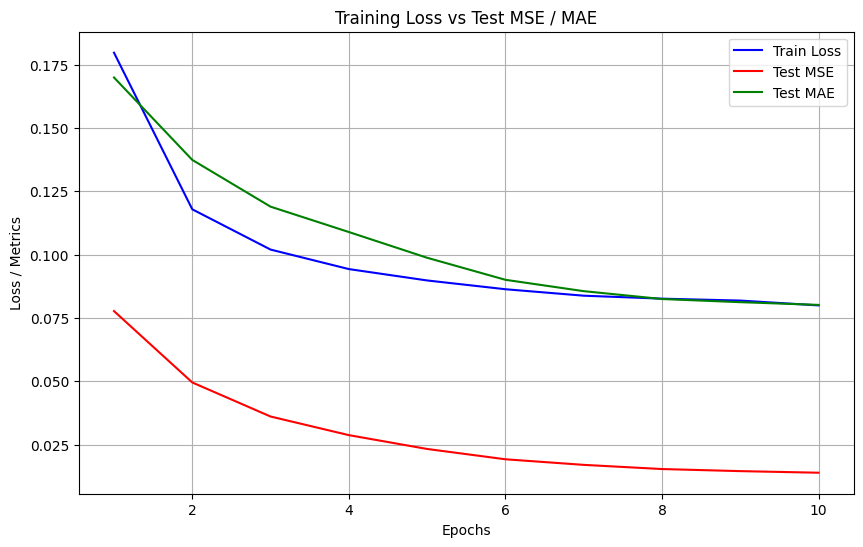

In [ ]:
# Plot training metrics


TEMP_RESULTS_DIR = os.path.join(BASE_DIR, "notebooks", "transformer", "temp_results")  # Prototype results directory
METRICS_PATH = os.path.join(TEMP_RESULTS_DIR, "training_metrics.json")

# Load training metrics
with open(METRICS_PATH, "r") as f:
    metrics_data = json.load(f)

train_losses = metrics_data["train_losses"]
test_mses = metrics_data["test_mses"]
test_maes = metrics_data["test_maes"]

# **Plot training and test metrics**
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, len(test_mses) + 1), test_mses, label="Test MSE", color="red")
plt.plot(range(1, len(test_maes) + 1), test_maes, label="Test MAE", color="green")

plt.xlabel("Epochs")
plt.ylabel("Loss / Metrics")
plt.title("Training Loss vs Test MSE / MAE")
plt.legend()
plt.grid(True)

# **Save the plot**
plot_filename = f"plot_embedder{'F' if freeze_embedder else 'U'}_wd{weight_decay}_dropout{head_dropout}.png"
plot_path = os.path.join(TEMP_RESULTS_DIR, plot_filename)
plt.savefig(plot_path)
print(f"Plot saved to: {plot_path}")

# **Display plot inline**
plt.show()


In [ ]:
# Check the length of the arrays
print(f"Number of ground truth values (trues): {len(trues)}")
print(f"Number of predicted values (preds): {len(preds)}")

# Check the shape of the arrays
print(f"Shape of trues: {trues.shape}")
print(f"Shape of preds: {preds.shape}")


Number of ground truth values (trues): 19891
Number of predicted values (preds): 19891
Shape of trues: (19891, 12, 1)
Shape of preds: (19891, 12, 1)


In [ ]:
# Load final model
checkpoint_path = os.path.join(BASE_DIR, "notebooks", "transformer", "checkpoints", "best_model.pth")
model.load_state_dict(torch.load(checkpoint_path))
print(f"Best model loaded from: {checkpoint_path}")

model.eval()

trues, preds = [], []  # reset any previous values

#!!In Collab the last shuffles testset is stored, but we dont  want the shuffled one. so we recreate the normal not shuffled testset
# Step 1: Recreate Datasets
train_dataset = InformerDataset(data_split="train", forecast_horizon=FORECAST_HORIZON, random_seed=13)
test_dataset = InformerDataset(data_split="test", forecast_horizon=FORECAST_HORIZON, random_seed=13)

# Step 2: Share fitted scaler
test_dataset.scaler = train_dataset.scaler

# Step 3: Create new test loader — UNGESHUFFELT!
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 4: Recompute predictions
model.eval()
trues, preds = [], []

with torch.no_grad():
    for timeseries, forecast, input_mask in tqdm(test_loader, desc="Evaluating"):
        timeseries = timeseries.float().to(device)
        forecast = forecast.float().to(device)
        input_mask = input_mask.to(device)

        output = model(x_enc=timeseries, input_mask=input_mask)

        trues.append(forecast.cpu().numpy())
        preds.append(output.forecast.cpu().numpy())

trues = np.concatenate(trues, axis=0)
preds = np.concatenate(preds, axis=0)



# Extract ground truth and predictions for the full test dataset
true_values = trues[:, 0, :]
pred_values = preds[:, 0, :]

# Reshape for inverse scaling
n_features = train_dataset.n_channels  # In case multiple features exist
true_values_reshaped = np.column_stack([true_values.flatten()] + [np.zeros_like(true_values.flatten())] * (n_features - 1))
pred_values_reshaped = np.column_stack([pred_values.flatten()] + [np.zeros_like(pred_values.flatten())] * (n_features - 1))

# Inverse transformation with the scaler
true_values_original = train_dataset.scaler.inverse_transform(true_values_reshaped)[:, 0]
pred_values_original = train_dataset.scaler.inverse_transform(pred_values_reshaped)[:, 0]

# Create timestamps

# Berechne Index: Trainingslänge + SEQ_LEN
train_len = len(train_dataset)
test_start_idx = train_len + SEQ_LEN
start_timestamp = pd.Timestamp(df["date"].iloc[test_start_idx])

print(f"[DEBUG] Auto-detected start timestamp: {start_timestamp}")

print(start_timestamp)
timestamps = [start_timestamp + pd.Timedelta(hours=i) for i in range(len(true_values_original))]


# Create DataFrame
df_comparison = pd.DataFrame({
    "Timestamp": timestamps,
    "True Consumption (MW)": true_values_original,
    "Predicted Consumption (MW)": pred_values_original
})

# Save CSV
results_filename = f"results_embedder{'F' if freeze_embedder else 'U'}_wd{weight_decay}_dropout{head_dropout}.csv"
results_path = os.path.join(TEMP_RESULTS_DIR, results_filename)
df_comparison.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")


In [ ]:
df_comparison.head(-1)

,Timestamp,True Consumption (MW),Predicted Consumption (MW)
0,2016-04-26 04:00:00,82610.0,87210.539062
1,2016-04-26 05:00:00,80450.0,86532.781250
2,2016-04-26 06:00:00,81670.0,87758.562500
3,2016-04-26 07:00:00,87470.0,92761.429688
4,2016-04-26 08:00:00,95380.0,100447.148438
...,...,...,...
19885,2018-08-02 17:00:00,168970.0,167208.906250
19886,2018-08-02 18:00:00,164370.0,162466.031250
19887,2018-08-02 19:00:00,155900.0,158097.578125
19888,2018-08-02 20:00:00,150860.0,153032.640625


In [ ]:
# **Additional evaluation metrics**
mse = mean_squared_error(df_comparison["True Consumption (MW)"], df_comparison["Predicted Consumption (MW)"])
rmse = np.sqrt(mse)
true_values = df_comparison["True Consumption (MW)"].values
predicted_values = df_comparison["Predicted Consumption (MW)"].values
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
r2 = r2_score(df_comparison["True Consumption (MW)"], df_comparison["Predicted Consumption (MW)"])

# Print results
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

# Define save path
# Dynamischer Dateiname für Evaluation
eval_filename = f"eval_embedder{'F' if freeze_embedder else 'U'}_wd{weight_decay}_dropout{head_dropout}.json"
eval_metrics_path = os.path.join(TEMP_RESULTS_DIR, eval_filename)

# Store metrics in dictionary
eval_metrics = {
    "RMSE": float(rmse),
    "MAPE": float(mape),
    "R2": float(r2)
}

# Save to JSON
with open(eval_metrics_path, "w") as f:
    json.dump(eval_metrics, f)

print(f"Evaluation metrics saved to: {eval_metrics_path}")

RMSE: 3412.211
MAPE: 2.05%
R²: 0.979
Evaluation metrics saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/temp_results/eval_embedderU_wd1e-05_dropout0.1.json


Comparison plot saved to: /content/drive/My Drive/Energy_prediction/notebooks/transformer/temp_results/comparison_embedderU_wd1e-05_dropout0.1.png


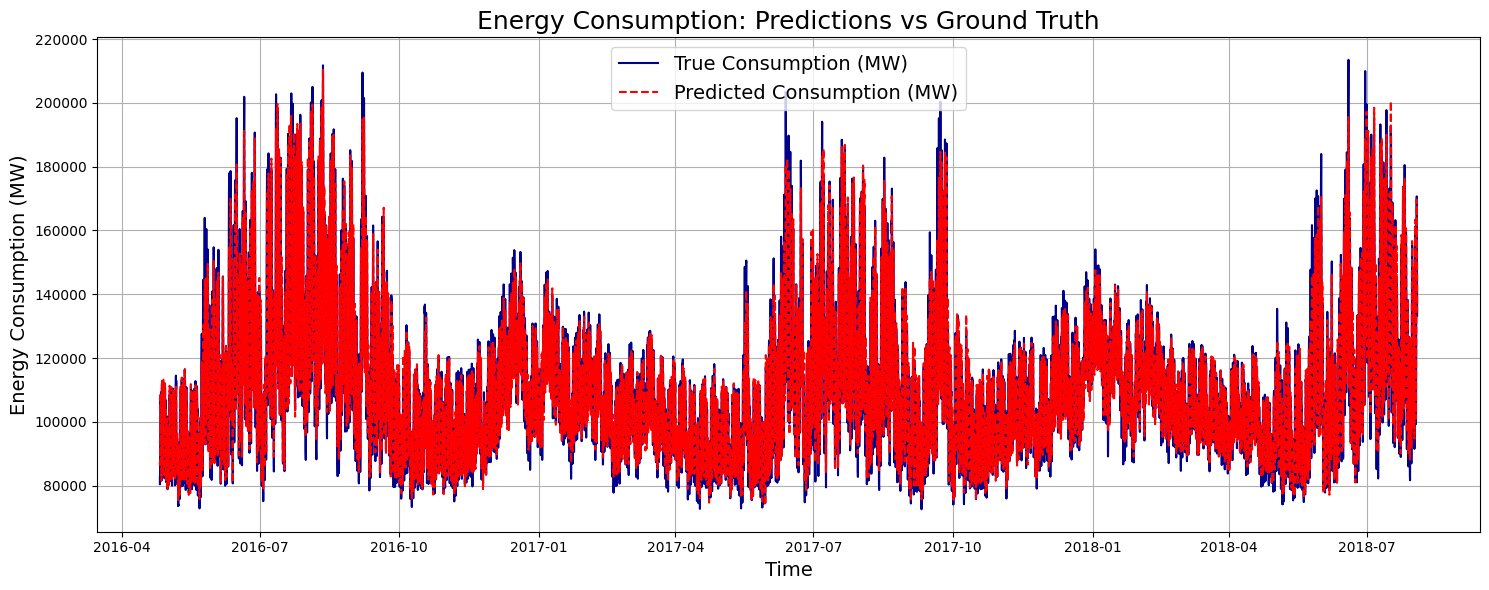

In [ ]:
# Plot true values vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(df_comparison["Timestamp"], df_comparison["True Consumption (MW)"], label="True Consumption (MW)", color="darkblue")
plt.plot(df_comparison["Timestamp"], df_comparison["Predicted Consumption (MW)"], label="Predicted Consumption (MW)", color="red", linestyle="--")

# Add title and axis labels
plt.title("Energy Consumption: Predictions vs Ground Truth", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Energy Consumption (MW)", fontsize=14)

# Add legend
plt.legend(fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Save plot
plot_filename = f"comparison_embedder{'F' if freeze_embedder else 'U'}_wd{weight_decay}_dropout{head_dropout}.png"
comparison_plot_path = os.path.join(TEMP_RESULTS_DIR, plot_filename)
plt.savefig(comparison_plot_path)
print(f"Comparison plot saved to: {comparison_plot_path}")

# Display plot
plt.show()

In [ ]:
# Clearer plot for the first month
# Filter data for the first month
first_month_start = df_comparison["Timestamp"].min()
first_month_end = first_month_start + pd.Timedelta(days=25)
df_first_month = df_comparison[(df_comparison["Timestamp"] >= first_month_start) & (df_comparison["Timestamp"] <= first_month_end)]

# Plot true values vs predicted values for the first month
plt.figure(figsize=(15, 6))
plt.plot(df_first_month["Timestamp"], df_first_month["True Consumption (MW)"], label="True Consumption (MW)", color="darkblue")
plt.plot(df_first_month["Timestamp"], df_first_month["Predicted Consumption (MW)"], label="Predicted Consumption (MW)", color="red", linestyle="--")

# Add title and axis labels
plt.title("Energy Consumption (First Month): Predictions vs Ground Truth", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Energy Consumption (MW)", fontsize=14)

# Add legend
plt.legend(fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Save plot
plot_filename = f"comparison_1month_embedder{'F' if freeze_embedder else 'U'}_wd{weight_decay}_dropout{head_dropout}.png"
comparison_plot_path = os.path.join(TEMP_RESULTS_DIR, plot_filename)
plt.savefig(comparison_plot_path)
print(f"Comparison plot saved to: {comparison_plot_path}")

# Display plot
plt.show()